In [52]:
#Imports 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#For plotting line segments
from matplotlib.collections import LineCollection

#Interactive backend
%matplotlib nbagg

In [53]:
#define the class Joint which will classify the joints

class Joint:
    '''
    parent   : Reference to Rope object
    id       : Index in parent's list of Joints
    held     : Boolean for interactivity
    x        : Current horizontal position
    y        : Current vertical position
    px       : Previous horizontal position
    py       : Previous vertical position
    bounce   : Percentage velocity retained upon collision with boundary
    fixed    : Boolean for update rules. Fixed points don't move.
    '''
    def __init__(self, x, y, fixed = False, bounce = 0.4):
        self.parent = None #Specified when list of Joints are assigned to Rope
        self.id     = None #Specified when list of Joints are assigned to Rope

        self.held   = False #True if dragged
        self.fixed = fixed
        self.bounce = bounce #How much velocity is kept after wall collision


        #Initialize position with 0 speed.
        #Note that Verlet integration does not have a velocity attribute!
        #See the naming conventions from docstring above.
        #Your code here
        self.x = x
        self.y = y
        self.px = x
        self.py = y


    @property
    #Get position of Joint
    def pos(self):
        return (self.x, self.y)


    #Update according to Verlet integration
    #with added gravitational acceleration
    def update(self):
        #Verlet integration update code goes here!
        newx = 2*self.x - self.px
        newy = 2*self.y - self.py - self.parent.g*self.parent.dt*self.parent.dt
        self.x, self.y = newx, newy

    #If joint has crossed the bounds of the box, set it back to the bound
    #and reflect its velocity, scaled by the bounce factor.
    def check_boundary(self):
        vx = (self.x-self.px)*self.bounce
        vy = (self.y-self.py)*self.bounce

        box_size = self.parent.box_size

        #Boundary check code
        if self.x > box_size:
            self.x = box_size
            self.px = self.x + vx
        if self.x < -box_size:
            self.x = -box_size
            self.px = self.x + vx
        if self.y > box_size:
            self.y = box_size
            self.py = self.y + vx
        if self.y < -box_size:
            self.y = -box_size
            self.py = self.y + vy

        #Hint: How can you keep the speed but reverse the direction
        # when bouncing, without a velocity term?


In [54]:
class Rope:
    '''
    joints   : List of Joint objects. Are connected to their neighbours
    seglen   : Target length of each segment
    g        : Gravitational acceleration
    dt       : Time step size
    box_size : Sets xlim and ylim of plot
    stiffness: Amount of iterations the constrain loop makes
    '''
    def __init__(self, joints, segmentlen, step_size, stiffness = 4, gravity = 9.81, box_size = 100):
        for i, joint in enumerate(joints):
            joint.parent = self
            joint.id     = i

        self.joints = joints
        self.seglen = segmentlen
        self.g = gravity
        self.dt = step_size
        self.box_size = box_size
        self.stiffness = stiffness

    @property
    #Get true length of rope
    #Should return a float
    def length(self):
        length = 0
        for i in self.f_i[:-1]:
            length += self.dist(i, i+1)
        return length

    @property
    #Get list of joint positions, [(x1,y1), (x2,y2), ...]
    def pos(self):
        return np.transpose([(j.x,j.y) for j in self.joints])

    @property
    #Get indices of fixed joints
    def f_i(self):
        return np.transpose([j.id for j in self.joints if j.fixed])

    @property
    #Get segment length errors for colormapping
    #Should return a list of errors
    def errors(self):
        seglens = [self.dist(i, i+1) for i in range(len(self.joints)-1)]
        return [self.seglen - dist for dist in seglens]

    @property
    #Get segments in the form [[(x1,y1),(x2,y2)], [(x2,y2),(x3,y3)], ...]
    def segments(self):
        return [[self.joints[i].pos,self.joints[i+1].pos] for i in range(len(self.joints)-1)]


    #Takes indices to joints and returns their Euclidean distance
    def dist(self, i1, i2):
        j1 = self.joints[i1]
        j2 = self.joints[i2]
        return np.linalg.norm([j1.x-j2.x,j1.y-j2.y])

    def constrain(self, i1, i2):
        #Your code goes here - make sure that the segments are not too long
        #See the optional reading if confused: <https://youtu.be/FcnvwtyxLds?t=516>
        j1 = self.joints[i1]
        j2 = self.joints[i2]
        targetlen = self.seglen

        #Error ratio compared to target distance
        err = targetlen - self.dist(i1, i2)
        err_ratio = err/targetlen


        #If both points are fixed, don't change them
        if self.joints[i1].fixed and self.joints[i2].fixed:
            pass

        #If one is fixed, move the other to the correct distance
        elif j1.fixed:
            j2.x *= (1+err_ratio)
            j2.y *= (1+err_ratio)
        
        elif j2.fixed:
            j1.x *= (1+err_ratio)
            j1.y *= (1+err_ratio)

        #If neither is fixed, move both equally to correct distance
        else:
            j1.x *= ((1 + err_ratio)/2)
            j1.y *= ((1 + err_ratio)/2)
            j2.x *= ((1 + err_ratio)/2)
            j2.y *= ((1 + err_ratio)/2)


    def update(self):
        #Update with Verlet integration
        for j in self.joints:
            j.update()
        #Apply constraint pass a number of times
        for _ in range(self.stiffness):
            for i in range(len(self.joints)-1):
                self.constrain(i,i+1)
        #Resolve collisions with boundary of plot.
        for j in self.joints:
            j.check_boundary()

In [55]:
#When mouse is moved over plot
def onmove(event):
    global mp, target
    #If the mouse is pressed
    if mp:
        #Position of event on the plot
        e_pos = np.asarray([event.xdata, event.ydata])

        #If cursor not moved beyond plot
        if event.xdata != None and event.ydata != None:
            #Update held object's position
            rope.joints[target].x = e_pos[0]
            rope.joints[target].y = e_pos[1]

        #If moving beyond plot
        else:
            #Drop held object
            offclick(event)

#When mouse is clicked on plot
def onclick(event):
    global mp, target

    #Mouse was clicked
    mp = True

    #Log click location
    e_pos = np.asarray([event.xdata, event.ydata])
    target = None #When a target joint is found, set this to Joint.id

    #If clicked near fixed joint, pick it up
    idxs = rope.f_i
    for i in idxs:
        j = rope.joints[i]

        #Find the distance to the joint, and decide if it is close enough
        #A good threshold is rope.box_size/10
        if np.linalg.norm([j.x-e_pos[0],j.y-e_pos[1]]) < rope.box_size/10:
            target = j.id
            break

    #If we didn't click near a fixed joint, what is the closest joint?
    if target == None:
        #Find the closest joint!
        #Your code here
        temp_targ = 0
        for i in range(len(self.joints)):
            temp_j = rope.joints[temp_targ]
            temp_i = rope.joints[i]
            if np.linalg.norm([temp_i.x-e_pos[0],temp_i.y-e_pos[1]]) < np.linalg.norm([temp_j.x-e_pos[0],temp_j.y-e_pos[1]]):
                temp_targ = temp_i.id
        target = temp_targ

    #If we're holding a joint...
    if target != None:
        #...let it know that it's being held...
        if rope.joints[target].fixed:
            #Fixed points don't need a change in attributes
            pass
        else:
            #Non-fixed points are made fixed while held
            rope.joints[target].held = True
            rope.joints[target].fixed = True

        #... and move it to the cursor
        #Jatin, if you don't like stretchy rope, you can insert a constraint
        #relative to the neighbours of the held joints here.
        rope.joints[target].x = e_pos[0]
        rope.joints[target].y = e_pos[1]

#When mouse is released or moved off plot
def offclick(event):
    global mp, target
    #Mouse was released
    mp = False

    #If the held object was initially non-fixed, make it non-fixed again
    if rope.joints[target].held:
        rope.joints[target].held = False
        rope.joints[target].fixed = False

    #Drop held object
    target = None

In [60]:
#Animation loop to be called each frame
def animate(i):
    rope.update() #Update the rope's position
    line.set_segments(rope.segments) #Update position plot of rope
    line.set_color(colormap(rope.errors)) #Update colors of segments
    title.set_text(f'Rope len: ({rope.length:.2f})') #Update title

    #Return artist, i.e. our plot object
    return line,


<IPython.core.display.Javascript object>


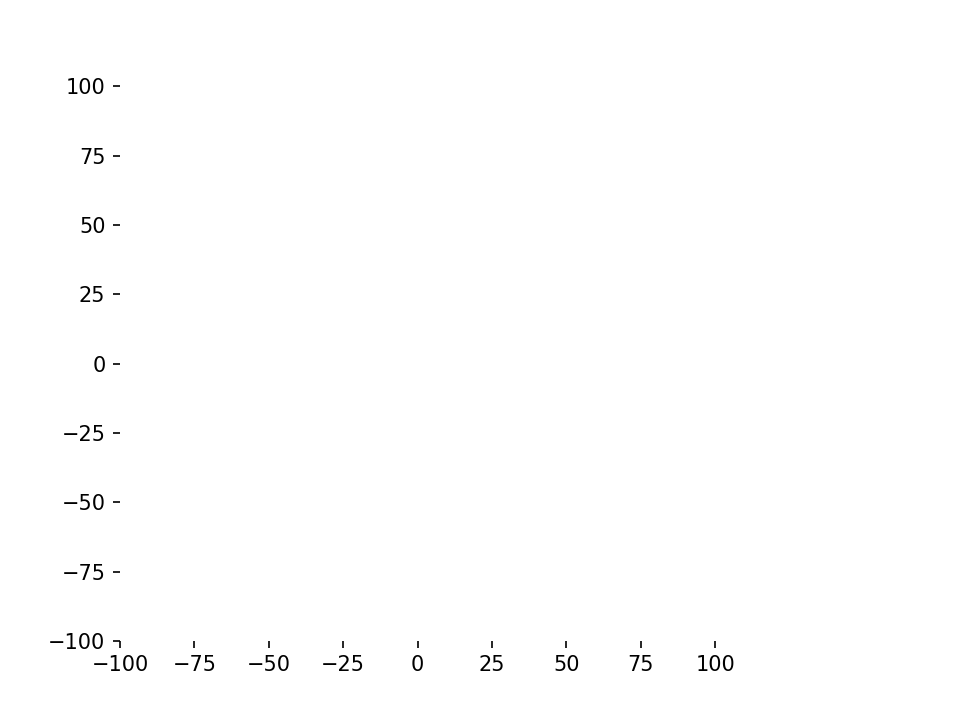

<ipython-input-54-105e385d3639>:58: RuntimeWarning: invalid value encountered in double_scalars
  return np.linalg.norm([j1.x-j2.x,j1.y-j2.y])


In [61]:
colormap = plt.get_cmap('coolwarm') #Colormap for errors
mp = False #Mouse pressed
target = None #Joint to hold

#Set rope parameters
segmentlen = 2 #Target lenght of segments
stiff = 4 #Stiffness
g = 4 #Gravitational acceleration

####Sample ropes:####

#Loose rope, try picking it up after it has fallen!
#joints = [Joint(segmentlen*i,75-0.5*i) for i in range(31)]

#Rope hanging from one end
joints = [Joint(0,75, fixed = True), *[Joint(segmentlen*i,75) for i in range(1,61)]]

#Suspended rope between two points
#joints = [Joint(0,75, fixed = True),
#          *[Joint(np.sqrt(segmentlen)*i,75-np.sqrt(segmentlen)*i) for i in range(1,60)],
#          Joint(np.sqrt(segmentlen)*60,75-np.sqrt(segmentlen)*60, fixed = True)]

#####################

#Set animation parameters
frame_r = 80
step_size = 1/frame_r

#Create rope
rope = Rope(joints, segmentlen, step_size, stiffness = stiff, gravity = g)


#Create figure
fig, ax = plt.subplots()
title = ax.set_title(f'Rope len: ({rope.length:.2f})')

ax.set_xlim(-rope.box_size, rope.box_size)
ax.set_ylim(-rope.box_size, rope.box_size)

#Plot rope as segments, colored on the coolwarm cmap according to rope.errors
lc = LineCollection(rope.segments, cmap = colormap)
lc.set_array(rope.errors)
lc.set_clim([-segmentlen,segmentlen])
line = ax.add_artist(lc) #This is the actual 'artist' object we will update

#Add colorbar to plot
cbar = fig.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Error in segment length', rotation=270)

#Create animation using the animate() function
#myAnimation = animation.FuncAnimation(fig, animate, frames=1, interval=1000/frame_r, blit=True)
animate(1)

#Connect event listeners for moving and pressing/releasing mouse
fig.canvas.mpl_connect('motion_notify_event', onmove)
fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('button_release_event', offclick)

#Show interactive simulation to user
plt.show()

#print([rope.dist(i, i+1) for i in range(len(rope.joints)-1)])